# Spend engine
## Objective
Develop code for generating spending projections based on:
- underlying lifecycle profile (launch to patent expiry etc)
- successive cohorts of launches
 
Allow for:
- growth between cohorts
- continuing spend at end of lifecycle
- discontinuous changes - eg one-off multiplication of profile
 
Plot locally for now, but will want to integrate with web app / UI.
 
## Status
Based on the `SpendObject` class.  Instances takes a *discontinous* profile (as a `np.array`), timings, growth rates etc.  Can then return spend projections (as pandas `pd.Series`) for a given time period with the `[instance].get_pd(periods)` method.  
Basic engine seems to work.  
Can use any time periods / intervals, but currently won't deal with dates as such

## Notes
Leaves profile generation to some other functionality.  Could use three approaches to generate the input:
- directly generate the monthly profile
- generate from a continuous function
- generate from a set of user-defined points

## Next up
- Sort so it can deal with eg MM YYYY date formats (use pandas date format).  [Remember to divide annual growth rates etc by 12]  
- Maybe allow a time range input to `.get_pd()`?  
- Options for dumping eg to excel?  
- Actually check the results are right!  
- Unit tests  

## Main code

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [4]:
class SpendObject:
    '''Defines a body of spending based on a period of launches (cohorts), each based on a fundamental 
    profile and cohort growth (i.e. change in magnitude of profile over successive cohorts).
    The period for calculating spend is open:  the last period in the profile is taken to be the
    "terminal" spend, which continues indefinitely, changing according to the terminal growth rate 
    (this would normally be negative).
    '''
    def __init__(self, profile, launches_start, launches_stop, coh_growth=0, term_growth=0, scale=1, name='spend_obj'):
        self.raw_profile = profile
        self.profile = profile * scale
        self.prof_scale = scale
        self.l_start = launches_start
        self.l_stop = launches_stop
        self.launch_pers = self.l_stop +1 - self.l_start
        self.prof_len = len(profile)
        self.coh_growth = coh_growth
        self.term_growth = term_growth
        self.term_value = profile[-1]
        self.name = name       
        width = 30
        self._info = {"name": self.name,
                     "first launch period": self.l_start,
                     "last launch period": self.l_stop,
                     "profile length": self.prof_len,
                     "profile scaling": self.prof_scale,
                     "profile max value (scaled)": max(self.profile),
                     "profile max period": self.profile.argmax(axis=0),
                     "terminal value": self.term_value,
                     "cohort growth rate": self.coh_growth,
                     "terminal growth rate": self.term_growth}


########################################## MAIN FUNCTION #################################################

    # Takes a point in time (eg year or other period), calculates spend in that period on all cohorts
    # (i.e. launches from a given previous period eg year)   
    
            
    def _spender(self, spend_per, debug=False):
        
        # NB - USES ZERO-BASED INDEXING FOR EVERYTHING
        
        # First, define the frame by going back from the spend period by the number of launch periods
        # This must give the actual indexes of the relevant elements of the profile for iterating
        # Zero based, and wants to go one past the end (that's how iteration works)
        
        frame = (max(0, spend_per - self.launch_pers), spend_per+1)   
        
            # eg if spend_per is 5 (6 periods) and there are 2 cohorts, then want indices 4-5
            # so frame is (3,6)
        
        f_start, f_end = frame
        last_coh = min(self.launch_pers, spend_per) # minus 1 to make zero based
        
        if debug:
            print("frame ", frame, "cohorts ", last_coh+1)
            titles = "prof point, coh id, raw val, coh adj, term adj, total adj,   val".split(",")
            pads = [len(t)-1 for t in titles]
            print(" |".join(titles))

        # Iterate through the frame (i.e. through the cohorts), yielding the spend at the
        # corresponding profile point, adjusted as necessary. 
        # If the profile point is beyond the terminal, then calculate appropriately
       
        for i, prof_point in enumerate(range(f_start, f_end)):
            
            # Helps to know which cohort we're on.  Last period in  frame corresponds to the zeroth cohort.
            # So the first will correspond to the last launch period (minus 1 to make start at zero).  
            # Then iterate through with the index
            coh_id = last_coh - i
            coh_adj = (1+self.coh_growth)**coh_id # used to adjust for growth between cohorts
            
            if debug: print(str(prof_point).rjust(pads[0]+1), "|", 
                            str(coh_id).rjust(pads[1]), "|", end="") 
                            
            
            # As long as the period is within the profile, yield the corresponding profile point
            if prof_point < self.prof_len: # length is one past the last index
                val = self.profile[prof_point] * coh_adj # adjust for cohort growth
                
                if debug: print(str(self.profile[prof_point]).rjust(pads[2]), " |", 
                                  "{0:.3f}".format(coh_adj).rjust(pads[3]),  "|",
                                  "-".rjust(pads[4]), "|", 
                                  "{0:.3f}".format(coh_adj).rjust(pads[5]), "|", 
                                  "{0:.3f}".format(val).rjust(pads[6])) 
                yield val
            
            # If the period is beyond the profile, use the terminal value
            else:
                # adjust the terminal value by the cohort growth, then for change after terminal period
                term_adj = (1+self.term_growth)**(prof_point - self.prof_len+1)
                val = self.term_value * coh_adj * term_adj
                if debug: print(str(self.term_value).rjust(pads[2]), " |", 
                                  "{0:.3f}".format(coh_adj).rjust(pads[3]),  "|",
                                  "{0:.3f}".format(term_adj).rjust(pads[4]), "|", 
                                  "{0:.3f}".format(term_adj*coh_adj).rjust(pads[5]), "|", 
                                  "{0:.3f}".format(val).rjust(pads[6])) 
                yield val

################################################# --- ENDS --- #################################################


    def point_spend(self, spend_per):
        return sum(self._spender(spend_per))
    
    def __getitem__(self, sl):
        # test if it's a single index, rather than a slice
        if isinstance(sl,int):
            return sum(self._spender(sl))
        else:
            slice_out = []
            for i in range(sl.start, sl.stop):
                slice_out.append(sum(self._spender(i)))
            return slice_out

    def __repr__(self):
        outlist = []
        for key in self._info:
            temp_string = key.ljust(27) + str(self._info[key]).rjust(10)
            outlist.append(temp_string)
        return "\n".join(outlist)
    
    def get_np(self, max_per, debug=False):
        np_out_list = []
        if debug: print(self.__repr__())
        for i, per in enumerate(range(max_per)):
            if debug: print("\nGetting period ", per)
            res = sum(self._spender(per, debug))
            if debug: print("Period ", per, "result ", res)
            np_out_list.append(res)
        return(np.array(np_out_list))
    
    def get_pd(self, max_per, debug=False):
        return pd.Series(self.get_np(max_per, debug=debug), index=range(self.l_start, self.l_start+max_per), name=self.name)
        

#_______________________________________________________________________________________________________________#
    

## Usage
First create some profiles

In [5]:
test_profile = np.array([1,2,5,10,11,12,1])
test_profile1 = np.array([1]*5)

### Demos
- create a spend object
- return object (repr) 
- create pd (with debug)
- plot
- concat and plot

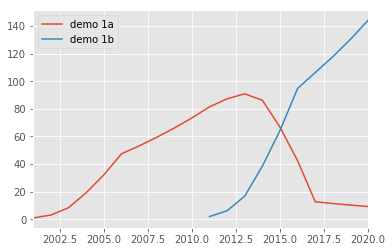

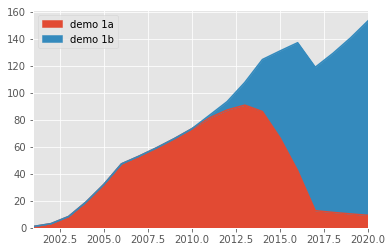

In [6]:
demo_1a = SpendObject(test_profile, 2001, 2010, 0.1, -0.1, 1, "demo 1a")
pd_1a = demo_1a.get_pd(20, debug=False)

demo_1b = SpendObject(test_profile, 2011, 2020, 0.1, -0.1, 2, "demo 1b")
pd_1b = demo_1b.get_pd(10, debug=False)

pd.concat([pd_1a, pd_1b], axis=1).plot()

pd.concat([pd_1a, pd_1b], axis=1).plot(kind="area", stacked=True)

### NB need to upgrade successive objects if the first has had growth

These look odd, with a large gap / notch between the two periods.  But it's just because the second period is starting from the same basic profile - and the growth that's built up by the end of the first period is rubbed off.

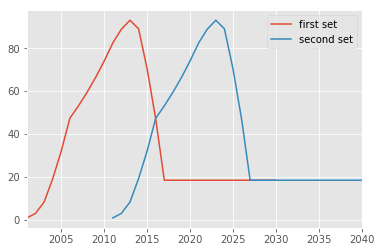

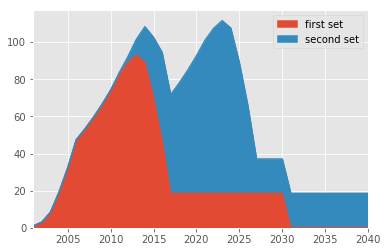

In [7]:
coh0 = SpendObject(test_profile, 2001, 2010, 0.1, 0, 1, "first set")
pd0 = coh0.get_pd(30, debug=False)

coh1 = SpendObject(test_profile, 2011, 2020, 0.1, 0, 1, "second set")
pd1 = coh1.get_pd(30)

pd.concat([pd0, pd1], axis=1).plot()
pd.concat([pd0, pd1], axis=1).plot(kind='area', stacked=True)

# Scratch

In [164]:
pd.date_range('2013', periods=6, freq='M')

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30'],
              dtype='datetime64[ns]', freq='M')